In [221]:
import os
import pandas as pd
import gc

# base

In [222]:
df_base = pd.read_parquet(r"C:\Users\mau_a\OneDrive\Área de Trabalho\home-credit-credit-risk-model-stability\parquet_files\train\train_base.parquet", engine='pyarrow')

# Filtra apenas as linhas com case_id <= 100000
df_base_amostra = df_base[df_base['case_id'] <= 100000]


# appl_prev

In [223]:
# Caminho da pasta
pasta = r"C:\Users\mau_a\OneDrive\Área de Trabalho\home-credit-credit-risk-model-stability\parquet_files\train"

# Lista todos os arquivos relevantes
arquivos = [
    os.path.join(pasta, f)
    for f in os.listdir(pasta)
    if f.startswith("train_applprev_") and f.endswith(".parquet")
]

dataframes_filtrados = []

for arquivo in arquivos:
    # Lê só a coluna 'case_id' para decidir se o arquivo é relevante
    df_case_id = pd.read_parquet(arquivo, columns=['case_id'], engine='pyarrow')

    # Verifica se vale a pena ler o arquivo completo
    if df_case_id['case_id'].max() < 100000:
        # Caso o máximo seja menor que 100000, lê só as linhas filtradas direto da coluna
        df_temp = df_case_id[df_case_id['case_id'] <= 100000]
    else:
        # Lê arquivo completo e aplica filtro mais seguro
        df_temp = pd.read_parquet(arquivo, engine='pyarrow')
        df_temp = df_temp[df_temp['case_id'] <= 100000]

    if not df_temp.empty:
        # Converte o tipo para economizar memória
        df_temp['case_id'] = df_temp['case_id'].astype('int32')
        dataframes_filtrados.append(df_temp)

    # Limpeza explícita de memória
    del df_case_id, df_temp
    gc.collect()

# Concatena os dados filtrados
df_prev_amostra = pd.concat(dataframes_filtrados, ignore_index=True)

print(f"Arquivos processados: {len(arquivos)}")
print(f"Total de linhas após filtro: {len(df_prev_amostra)}")




Arquivos processados: 3
Total de linhas após filtro: 167093


In [224]:
df_prev_amostra = df_prev_amostra.drop_duplicates(subset='case_id', keep='first')

In [225]:
df_merge = pd.merge(df_base_amostra, df_prev_amostra, how='outer', on='case_id')

In [226]:
def clean_object_columns(df):
    """
    Remove colunas do tipo 'object' que terminam com 'D' e
    converte colunas 'object' terminadas em 'M' para 'category'.
    """
    # Identifica colunas do tipo 'object'
    object_columns = df.select_dtypes(include='object').columns

    for col in object_columns:
        if col.endswith('D'):
            df.drop(columns=[col], inplace=True)
        elif col.endswith('M') or col.endswith('L') or col.endswith('T'):
            df[col] = df[col].astype('category')

    return df

In [227]:
df_merge = clean_object_columns(df_merge)


In [228]:
df_merge = df_merge.drop(columns=['MONTH','WEEK_NUM', 'date_decision'])

# credit_bureau

In [229]:
# Caminho da pasta
pasta = r"C:\Users\mau_a\OneDrive\Área de Trabalho\home-credit-credit-risk-model-stability\parquet_files\train"

# Lista os arquivos relevantes
arquivos = [
    os.path.join(pasta, f)
    for f in os.listdir(pasta)
    if f.startswith("train_credit_bureau") and f.endswith(".parquet")
]

# Lista para armazenar os DataFrames filtrados
dataframes_filtrados = []

for arquivo in arquivos:
    # Etapa 1: Lê apenas a coluna 'case_id' para verificar se precisa continuar
    df_case_id = pd.read_parquet(arquivo, columns=['case_id'], engine='pyarrow')
    
    if df_case_id['case_id'].min() > 100000:
        continue  # ignora esse arquivo completamente
    elif df_case_id['case_id'].max() < 0:
        continue  # sem dados úteis
    
    # Etapa 2: Lê o arquivo completo, filtra e adiciona se relevante
    df_temp = pd.read_parquet(arquivo, engine='pyarrow')
    df_temp = df_temp[df_temp['case_id'] <= 100000]
    
    if not df_temp.empty:
        # (opcional) reduzir o uso de memória convertendo tipos
        df_temp['case_id'] = df_temp['case_id'].astype('int32')
        dataframes_filtrados.append(df_temp)
    
    # Libera memória explicitamente
    del df_case_id, df_temp
    gc.collect()

# Concatena somente os dados filtrados
df_credit_amostra = pd.concat(dataframes_filtrados, ignore_index=True)

# Informações
print(f"Arquivos processados: {len(arquivos)}")
print(f"Total de linhas após filtro: {len(df_credit_amostra)}")


Arquivos processados: 17
Total de linhas após filtro: 4236835


In [230]:
df_credit_amostra = df_credit_amostra.drop_duplicates(subset='case_id', keep='first')

In [231]:
df_merge = pd.merge(df_merge, df_credit_amostra, how='outer', on='case_id')

In [232]:
def unify_merge_columns(df):
    # Identifica todas as colunas que terminam em _x
    cols_x = [col for col in df.columns if col.endswith('_x')]

    for col_x in cols_x:
        # Nome base da coluna sem o sufixo
        base_col = col_x[:-2]
        col_y = base_col + '_y'

        if col_y in df.columns:
            # Cria a coluna unificada com valores de _x e substitui NaNs com valores de _y
            df[base_col] = df[col_x].combine_first(df[col_y])
            # Remove as colunas antigas
            df.drop(columns=[col_x, col_y], inplace=True)
        else:
            # Se não existe _y correspondente, só renomeia _x para base_col
            df.rename(columns={col_x: base_col}, inplace=True)

    return df


# Uso
df_merge = unify_merge_columns(df_merge)


In [233]:
clean_object_columns(df_merge)


,case_id,target,actualdpd_943P,annuity_853A,byoccupationinc_3656910L,cancelreason_3545846M,childnum_21L,credacc_actualbalance_314A,credacc_credlmt_575A,credacc_maxhisbal_375A,...,residualamount_127A,residualamount_3940956A,subjectrole_326M,subjectrole_43M,totalamount_503A,totalamount_881A,pmts_dpdvalue_108P,pmts_pmtsoverdue_635A,num_group1,num_group2
0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,0.0,640.2,NaN,a55475b1,0.0,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
3,3,0,0.0,6140.0,NaN,P94_109_143,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4,4,1,0.0,2556.6,NaN,P24_27_36,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57620,57625,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
57621,57626,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
57622,57627,0,0.0,4744.2,NaN,P94_109_143,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
57623,57628,0,0.0,4107.6,NaN,P94_109_143,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN


# deposit

In [234]:
df_deposit = pd.read_parquet(r"C:\Users\mau_a\OneDrive\Área de Trabalho\home-credit-credit-risk-model-stability\parquet_files\train\train_deposit_1.parquet", engine='pyarrow')

# Filtra apenas as linhas com case_id <= 100
df_deposit_amostra = df_deposit[df_deposit['case_id'] <= 100000]


In [235]:
df_deposit_amostra = df_deposit_amostra.drop_duplicates(subset='case_id', keep='first')

In [236]:
df_merge = pd.merge(df_merge, df_deposit_amostra, how='outer', on='case_id')

In [237]:
df_merge = unify_merge_columns(df_merge)

In [238]:
df_merge = clean_object_columns(df_merge)


# other

In [239]:
df_other = pd.read_parquet(r"C:\Users\mau_a\OneDrive\Área de Trabalho\home-credit-credit-risk-model-stability\parquet_files\train\train_other_1.parquet", engine='pyarrow')

# Filtra apenas as linhas com case_id <= 100
df_other_amostra = df_deposit[df_deposit['case_id'] <= 100000]

In [240]:
df_other_amostra = df_deposit_amostra.drop_duplicates(subset='case_id', keep='first')

In [241]:
df_merge = pd.merge(df_merge, df_other_amostra, how='outer', on='case_id')

In [242]:
df_merge = unify_merge_columns(df_merge)

In [243]:
df_merge = clean_object_columns(df_merge)

# person

In [244]:
# Caminho da pasta
pasta = r"C:\Users\mau_a\OneDrive\Área de Trabalho\home-credit-credit-risk-model-stability\parquet_files\train"

# Lista todos os arquivos relevantes
arquivos = [
    os.path.join(pasta, f)
    for f in os.listdir(pasta)
    if f.startswith("train_person_") and f.endswith(".parquet")
]

dataframes_filtrados = []

for arquivo in arquivos:
    # Lê só a coluna 'case_id' para decidir se o arquivo é relevante
    df_case_id = pd.read_parquet(arquivo, columns=['case_id'], engine='pyarrow')

    # Verifica se vale a pena ler o arquivo completo
    if df_case_id['case_id'].max() < 1000:
        # Caso o máximo seja menor que 1000, lê só as linhas filtradas direto da coluna
        df_temp = df_case_id[df_case_id['case_id'] <= 100000]
    else:
        # Lê arquivo completo e aplica filtro mais seguro
        df_temp = pd.read_parquet(arquivo, engine='pyarrow')
        df_temp = df_temp[df_temp['case_id'] <= 100000]

    if not df_temp.empty:
        # Converte o tipo para economizar memória
        df_temp['case_id'] = df_temp['case_id'].astype('int32')
        dataframes_filtrados.append(df_temp)

    # Limpeza explícita de memória
    del df_case_id, df_temp
    gc.collect()

# Concatena os dados filtrados
df_person_amostra = pd.concat(dataframes_filtrados, ignore_index=True)

print(f"Arquivos processados: {len(arquivos)}")
print(f"Total de linhas após filtro: {len(df_person_amostra)}")


Arquivos processados: 2
Total de linhas após filtro: 251222


In [245]:
df_person_amostra = df_prev_amostra.drop_duplicates(subset='case_id', keep='first')

In [246]:
df_merge = pd.merge(df_merge, df_person_amostra, how='outer', on='case_id')

In [247]:
df_merge = unify_merge_columns(df_merge)

In [248]:
df_merge = clean_object_columns(df_merge)

# static

In [249]:
# Caminho da pasta
pasta = r"C:\Users\mau_a\OneDrive\Área de Trabalho\home-credit-credit-risk-model-stability\parquet_files\train"

# Lista todos os arquivos relevantes
arquivos = [
    os.path.join(pasta, f)
    for f in os.listdir(pasta)
    if f.startswith("train_static_") and f.endswith(".parquet")
]

dataframes_filtrados = []

for arquivo in arquivos:
    # Lê só a coluna 'case_id' para decidir se o arquivo é relevante
    df_case_id = pd.read_parquet(arquivo, columns=['case_id'], engine='pyarrow')

    # Verifica se vale a pena ler o arquivo completo
    if df_case_id['case_id'].max() < 1000:
        # Caso o máximo seja menor que 1000, lê só as linhas filtradas direto da coluna
        df_temp = df_case_id[df_case_id['case_id'] <= 100000]
    else:
        # Lê arquivo completo e aplica filtro mais seguro
        df_temp = pd.read_parquet(arquivo, engine='pyarrow')
        df_temp = df_temp[df_temp['case_id'] <= 100000]

    if not df_temp.empty:
        # Converte o tipo para economizar memória
        df_temp['case_id'] = df_temp['case_id'].astype('int32')
        dataframes_filtrados.append(df_temp)

    # Limpeza explícita de memória
    del df_case_id, df_temp
    gc.collect()

# Concatena os dados filtrados
df_static_amostra = pd.concat(dataframes_filtrados, ignore_index=True)

print(f"Arquivos processados: {len(arquivos)}")
print(f"Total de linhas após filtro: {len(df_static_amostra)}")



Arquivos processados: 3
Total de linhas após filtro: 113886


In [250]:
df_static_amostra = df_static_amostra.drop_duplicates(subset='case_id', keep='first')

In [251]:
df_merge = pd.merge(df_merge, df_static_amostra, how='outer', on='case_id')

In [252]:
df_merge = unify_merge_columns(df_merge)

In [253]:
df_merge = clean_object_columns(df_merge)

# tax

In [254]:
# Caminho da pasta
pasta = r"C:\Users\mau_a\OneDrive\Área de Trabalho\home-credit-credit-risk-model-stability\parquet_files\train"

# Lista todos os arquivos relevantes
arquivos = [
    os.path.join(pasta, f)
    for f in os.listdir(pasta)
    if f.startswith("train_tax_registry_") and f.endswith(".parquet")
]

dataframes_filtrados = []

for arquivo in arquivos:
    # Lê só a coluna 'case_id' para decidir se o arquivo é relevante
    df_case_id = pd.read_parquet(arquivo, columns=['case_id'], engine='pyarrow')

    # Verifica se vale a pena ler o arquivo completo
    if df_case_id['case_id'].max() < 1000:
        # Caso o máximo seja menor que 1000, lê só as linhas filtradas direto da coluna
        df_temp = df_case_id[df_case_id['case_id'] <= 100000]
    else:
        # Lê arquivo completo e aplica filtro mais seguro
        df_temp = pd.read_parquet(arquivo, engine='pyarrow')
        df_temp = df_temp[df_temp['case_id'] <= 100000]

    if not df_temp.empty:
        # Converte o tipo para economizar memória
        df_temp['case_id'] = df_temp['case_id'].astype('int32')
        dataframes_filtrados.append(df_temp)

    # Limpeza explícita de memória
    del df_case_id, df_temp
    gc.collect()

# Concatena os dados filtrados
df_tax_amostra = pd.concat(dataframes_filtrados, ignore_index=True)

print(f"Arquivos processados: {len(arquivos)}")
print(f"Total de linhas após filtro: {len(df_tax_amostra)}")

Arquivos processados: 3
Total de linhas após filtro: 231050


In [255]:
df_tax_amostra = df_tax_amostra.drop_duplicates(subset='case_id', keep='first')

In [256]:
df_merge = pd.merge(df_merge, df_tax_amostra, how='outer', on='case_id')

In [257]:
df_merge = unify_merge_columns(df_merge)

In [258]:
df_merge = clean_object_columns(df_merge)

# TESTE

In [259]:
import os
import pandas as pd
import gc

# base

In [260]:
df_base = pd.read_parquet(r"C:\Users\mau_a\OneDrive\Área de Trabalho\home-credit-credit-risk-model-stability\parquet_files\test\test_base.parquet", engine='pyarrow')

# Filtra apenas as linhas com case_id <= 100000
df_base_amostra_teste = df_base[df_base['case_id'] <= 100000]

# appl_prev

In [261]:
# Caminho da pasta
pasta = r"C:\Users\mau_a\OneDrive\Área de Trabalho\home-credit-credit-risk-model-stability\parquet_files\test"

# Lista todos os arquivos relevantes
arquivos = [
    os.path.join(pasta, f)
    for f in os.listdir(pasta)
    if f.startswith("test_applprev_") and f.endswith(".parquet")
]

dataframes_filtrados = []

for arquivo in arquivos:
    # Lê só a coluna 'case_id' para decidir se o arquivo é relevante
    df_case_id = pd.read_parquet(arquivo, columns=['case_id'], engine='pyarrow')

    # Verifica se vale a pena ler o arquivo completo
    if df_case_id['case_id'].max() < 100000:
        # Caso o máximo seja menor que 100000, lê só as linhas filtradas direto da coluna
        df_temp = df_case_id[df_case_id['case_id'] <= 100000]
    else:
        # Lê arquivo completo e aplica filtro mais seguro
        df_temp = pd.read_parquet(arquivo, engine='pyarrow')
        df_temp = df_temp[df_temp['case_id'] <= 100000]

    if not df_temp.empty:
        # Converte o tipo para economizar memória
        df_temp['case_id'] = df_temp['case_id'].astype('int32')
        dataframes_filtrados.append(df_temp)

    # Limpeza explícita de memória
    del df_case_id, df_temp
    gc.collect()

# Concatena os dados filtrados
df_prev_amostra_teste = pd.concat(dataframes_filtrados, ignore_index=True)

print(f"Arquivos processados: {len(arquivos)}")
print(f"Total de linhas após filtro: {len(df_prev_amostra_teste)}")


Arquivos processados: 4
Total de linhas após filtro: 40


In [262]:
df_prev_amostra_teste = df_prev_amostra_teste.drop_duplicates(subset='case_id', keep='first')

In [263]:
df_merge_teste = pd.merge(df_base_amostra_teste, df_prev_amostra_teste, how='outer', on='case_id')

In [264]:
def clean_object_columns(df):
    """
    Remove colunas do tipo 'object' que terminam com 'D' e
    converte colunas 'object' terminadas em 'M' para 'category'.
    """
    # Identifica colunas do tipo 'object'
    object_columns = df.select_dtypes(include='object').columns

    for col in object_columns:
        if col.endswith('D'):
            df.drop(columns=[col], inplace=True)
        elif col.endswith('M') or col.endswith('L') or col.endswith('T'):
            df[col] = df[col].astype('category')

    return df

In [265]:
df_merge_teste = clean_object_columns(df_merge_teste)


In [266]:
df_merge_teste = df_merge_teste.drop(columns=['MONTH','WEEK_NUM', 'date_decision'])

# credit_bureau

In [267]:
# Caminho da pasta
pasta = r"C:\Users\mau_a\OneDrive\Área de Trabalho\home-credit-credit-risk-model-stability\parquet_files\test"

# Lista os arquivos relevantes
arquivos = [
    os.path.join(pasta, f)
    for f in os.listdir(pasta)
    if f.startswith("test_credit_bureau") and f.endswith(".parquet")
]

# Lista para armazenar os DataFrames filtrados
dataframes_filtrados = []

for arquivo in arquivos:
    # Etapa 1: Lê apenas a coluna 'case_id' para verificar se precisa continuar
    df_case_id = pd.read_parquet(arquivo, columns=['case_id'], engine='pyarrow')
    
    if df_case_id['case_id'].min() > 100000:
        continue  # ignora esse arquivo completamente
    elif df_case_id['case_id'].max() < 0:
        continue  # sem dados úteis
    
    # Etapa 2: Lê o arquivo completo, filtra e adiciona se relevante
    df_temp = pd.read_parquet(arquivo, engine='pyarrow')
    df_temp = df_temp[df_temp['case_id'] <= 100000]
    
    if not df_temp.empty:
        # (opcional) reduzir o uso de memória convertendo tipos
        df_temp['case_id'] = df_temp['case_id'].astype('int32')
        dataframes_filtrados.append(df_temp)
    
    # Libera memória explicitamente
    del df_case_id, df_temp
    gc.collect()

# Concatena somente os dados filtrados
df_credit_amostra_teste = pd.concat(dataframes_filtrados, ignore_index=True)

# Informações
print(f"Arquivos processados: {len(arquivos)}")
print(f"Total de linhas após filtro: {len(df_credit_amostra_teste)}")

Arquivos processados: 19
Total de linhas após filtro: 190


In [268]:
df_credit_amostra_teste = df_credit_amostra_teste.drop_duplicates(subset='case_id', keep='first')

In [269]:
df_merge_teste = pd.merge(df_merge_teste, df_credit_amostra_teste, how='outer', on='case_id')

In [270]:
def unify_merge_columns(df):
    # Identifica todas as colunas que terminam em _x
    cols_x = [col for col in df.columns if col.endswith('_x')]

    for col_x in cols_x:
        # Nome base da coluna sem o sufixo
        base_col = col_x[:-2]
        col_y = base_col + '_y'

        if col_y in df.columns:
            # Cria a coluna unificada com valores de _x e substitui NaNs com valores de _y
            df[base_col] = df[col_x].combine_first(df[col_y])
            # Remove as colunas antigas
            df.drop(columns=[col_x, col_y], inplace=True)
        else:
            # Se não existe _y correspondente, só renomeia _x para base_col
            df.rename(columns={col_x: base_col}, inplace=True)

    return df


# Uso

In [271]:
df_merge_teste = unify_merge_columns(df_merge_teste)

In [272]:
clean_object_columns(df_merge_teste)

,case_id,annualeffectiverate_199L,annualeffectiverate_63L,classificationofcontr_13M,classificationofcontr_400M,contractst_545M,contractst_964M,contractsum_5085717L,credlmt_230A,credlmt_935A,...,purposeofcred_722M,residualamount_1093A,residualamount_127A,residualamount_3940956A,subjectrole_326M,subjectrole_43M,totalamount_503A,totalamount_881A,pmts_dpdvalue_108P,pmts_pmtsoverdue_635A
0,57543,0.69,NaN,a55475b1,01f63ac8,a55475b1,7241344e,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,57549,46.79,NaN,a55475b1,ea6782cc,a55475b1,7241344e,NaN,17800.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,57551,8.28,NaN,a55475b1,ea6782cc,a55475b1,7241344e,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,57552,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,57569,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,57630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,57631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,57632,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,57633,34.50,34.5,ea6782cc,ea6782cc,7241344e,7241344e,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,57634,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# deposit

In [273]:
df_deposit_teste = pd.read_parquet(r"C:\Users\mau_a\OneDrive\Área de Trabalho\home-credit-credit-risk-model-stability\parquet_files\test\test_deposit_1.parquet", engine='pyarrow')

# Filtra apenas as linhas com case_id <= 100000
df_deposit_amostra_teste = df_deposit_teste[df_deposit_teste['case_id'] <= 100000]

In [274]:
df_deposit_amostra_teste = df_deposit_amostra_teste.drop_duplicates(subset='case_id', keep='first')

In [275]:
df_merge_teste = pd.merge(df_merge_teste, df_deposit_amostra_teste, how='outer', on='case_id')

In [276]:
df_merge_teste = unify_merge_columns(df_merge_teste)

In [277]:
df_merge_teste = clean_object_columns(df_merge_teste)

# other

In [278]:
df_other_teste = pd.read_parquet(r"C:\Users\mau_a\OneDrive\Área de Trabalho\home-credit-credit-risk-model-stability\parquet_files\test\test_other_1.parquet", engine='pyarrow')

# Filtra apenas as linhas com case_id <= 100
df_other_amostra_teste = df_deposit_teste[df_deposit_teste['case_id'] <= 100000]

In [279]:
df_other_amostra_teste = df_deposit_amostra_teste.drop_duplicates(subset='case_id', keep='first')

In [280]:
df_merge_teste = pd.merge(df_merge_teste, df_other_amostra_teste, how='outer', on='case_id')

In [281]:
df_merge_teste = unify_merge_columns(df_merge_teste)

In [282]:
df_merge_teste = clean_object_columns(df_merge_teste)

# person

In [283]:
# Caminho da pasta
pasta = r"C:\Users\mau_a\OneDrive\Área de Trabalho\home-credit-credit-risk-model-stability\parquet_files\test"

# Lista todos os arquivos relevantes
arquivos = [
    os.path.join(pasta, f)
    for f in os.listdir(pasta)
    if f.startswith("test_person_") and f.endswith(".parquet")
]

dataframes_filtrados = []

for arquivo in arquivos:
    # Lê só a coluna 'case_id' para decidir se o arquivo é relevante
    df_case_id = pd.read_parquet(arquivo, columns=['case_id'], engine='pyarrow')

    # Verifica se vale a pena ler o arquivo completo
    if df_case_id['case_id'].max() < 1000:
        # Caso o máximo seja menor que 1000, lê só as linhas filtradas direto da coluna
        df_temp = df_case_id[df_case_id['case_id'] <= 100000]
    else:
        # Lê arquivo completo e aplica filtro mais seguro
        df_temp = pd.read_parquet(arquivo, engine='pyarrow')
        df_temp = df_temp[df_temp['case_id'] <= 100000]

    if not df_temp.empty:
        # Converte o tipo para economizar memória
        df_temp['case_id'] = df_temp['case_id'].astype('int32')
        dataframes_filtrados.append(df_temp)

    # Limpeza explícita de memória
    del df_case_id, df_temp
    gc.collect()

# Concatena os dados filtrados
df_person_amostra_teste = pd.concat(dataframes_filtrados, ignore_index=True)

print(f"Arquivos processados: {len(arquivos)}")
print(f"Total de linhas após filtro: {len(df_person_amostra_teste)}")

Arquivos processados: 2
Total de linhas após filtro: 20


In [284]:
df_person_amostra_teste = df_prev_amostra_teste.drop_duplicates(subset='case_id', keep='first')

In [285]:
df_merge_teste = pd.merge(df_merge_teste, df_person_amostra_teste, how='outer', on='case_id')

In [286]:
df_merge_teste = unify_merge_columns(df_merge_teste)

In [287]:
df_merge_teste = clean_object_columns(df_merge_teste)

# static

In [288]:
# Caminho da pasta
pasta = r"C:\Users\mau_a\OneDrive\Área de Trabalho\home-credit-credit-risk-model-stability\parquet_files\test"

# Lista todos os arquivos relevantes
arquivos = [
    os.path.join(pasta, f)
    for f in os.listdir(pasta)
    if f.startswith("test_static_") and f.endswith(".parquet")
]

dataframes_filtrados = []

for arquivo in arquivos:
    # Lê só a coluna 'case_id' para decidir se o arquivo é relevante
    df_case_id = pd.read_parquet(arquivo, columns=['case_id'], engine='pyarrow')

    # Verifica se vale a pena ler o arquivo completo
    if df_case_id['case_id'].max() < 1000:
        # Caso o máximo seja menor que 1000, lê só as linhas filtradas direto da coluna
        df_temp = df_case_id[df_case_id['case_id'] <= 100000]
    else:
        # Lê arquivo completo e aplica filtro mais seguro
        df_temp = pd.read_parquet(arquivo, engine='pyarrow')
        df_temp = df_temp[df_temp['case_id'] <= 100000]

    if not df_temp.empty:
        # Converte o tipo para economizar memória
        df_temp['case_id'] = df_temp['case_id'].astype('int32')
        dataframes_filtrados.append(df_temp)

    # Limpeza explícita de memória
    del df_case_id, df_temp
    gc.collect()

# Concatena os dados filtrados
df_static_amostra_teste = pd.concat(dataframes_filtrados, ignore_index=True)

print(f"Arquivos processados: {len(arquivos)}")
print(f"Total de linhas após filtro: {len(df_static_amostra_teste)}")

Arquivos processados: 4
Total de linhas após filtro: 40


In [289]:
df_static_amostra_teste = df_static_amostra_teste.drop_duplicates(subset='case_id', keep='first')

In [290]:
df_merge_teste = pd.merge(df_merge_teste, df_static_amostra_teste, how='outer', on='case_id')

In [291]:
df_merge_teste = unify_merge_columns(df_merge_teste)

In [292]:
df_merge_teste = clean_object_columns(df_merge_teste)

# tax

In [293]:
# Caminho da pasta
pasta = r"C:\Users\mau_a\OneDrive\Área de Trabalho\home-credit-credit-risk-model-stability\parquet_files\test"

# Lista todos os arquivos relevantes
arquivos = [
    os.path.join(pasta, f)
    for f in os.listdir(pasta)
    if f.startswith("test_tax_registry_") and f.endswith(".parquet")
]

dataframes_filtrados = []

for arquivo in arquivos:
    # Lê só a coluna 'case_id' para decidir se o arquivo é relevante
    df_case_id = pd.read_parquet(arquivo, columns=['case_id'], engine='pyarrow')

    # Verifica se vale a pena ler o arquivo completo
    if df_case_id['case_id'].max() < 1000:
        # Caso o máximo seja menor que 1000, lê só as linhas filtradas direto da coluna
        df_temp = df_case_id[df_case_id['case_id'] <= 100000]
    else:
        # Lê arquivo completo e aplica filtro mais seguro
        df_temp = pd.read_parquet(arquivo, engine='pyarrow')
        df_temp = df_temp[df_temp['case_id'] <= 100000]

    if not df_temp.empty:
        # Converte o tipo para economizar memória
        df_temp['case_id'] = df_temp['case_id'].astype('int32')
        dataframes_filtrados.append(df_temp)

    # Limpeza explícita de memória
    del df_case_id, df_temp
    gc.collect()

# Concatena os dados filtrados
df_tax_amostra_teste = pd.concat(dataframes_filtrados, ignore_index=True)

print(f"Arquivos processados: {len(arquivos)}")
print(f"Total de linhas após filtro: {len(df_tax_amostra_teste)}")

Arquivos processados: 3
Total de linhas após filtro: 20


In [294]:
df_tax_amostra_teste = df_tax_amostra_teste.drop_duplicates(subset='case_id', keep='first')

In [295]:
df_merge_teste = pd.merge(df_merge_teste, df_tax_amostra_teste, how='outer', on='case_id')

In [296]:
df_merge_teste = unify_merge_columns(df_merge_teste)

In [297]:
df_merge_teste = clean_object_columns(df_merge_teste)

In [304]:
# Itera pelas colunas do df_merge
for col in df_merge.columns:
    if col != 'target' and col not in df_merge_teste.columns:
        df_merge.drop(columns=[col], inplace=True)

In [307]:
# Itera pelas colunas do df_merge_teste
for col in df_merge_teste.columns:
    if col != 'target' and col not in df_merge.columns:
        df_merge_teste.drop(columns=[col], inplace=True)

Iniciando busca por melhores hiperparâmetros...
Fitting 3 folds for each of 30 candidates, totalling 90 fits
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 1905, number of negative: 55720
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18086
[LightGBM] [Info] Number of data points in the train set: 57625, number of used features: 255
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033059 -> initscore=-3.375857
[LightGBM] [Info] Start training from score -3.375857
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

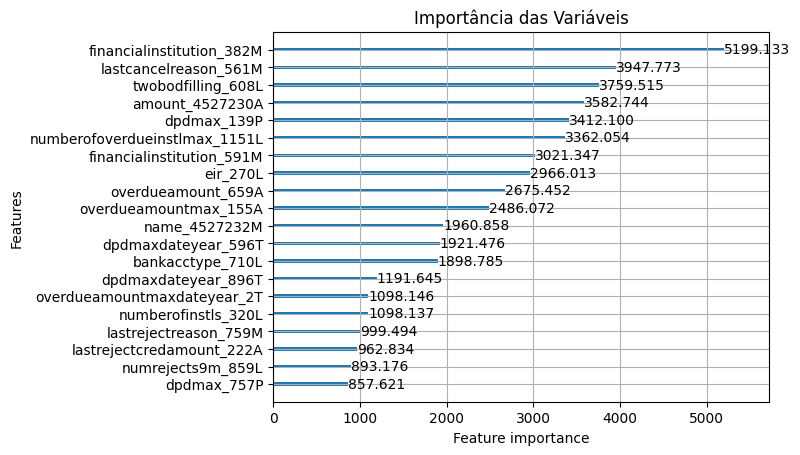

In [310]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt

# 1. Preparar os dados
# Treino (com target)
X_train = df_merge.drop(columns=['case_id', 'target'])
y_train = df_merge['target']

# Teste (sem target)
X_test = df_merge_teste.drop(columns=['case_id'])
case_id_test = df_merge_teste['case_id']

# 2. Definir modelo base
model = lgb.LGBMClassifier(objective='binary', boosting_type='gbdt', random_state=42)

# 3. Espaço de busca dos hiperparâmetros
param_dist = {
    'num_leaves': randint(20, 150),
    'max_depth': randint(3, 15),
    'learning_rate': uniform(0.01, 0.1),
    'n_estimators': randint(50, 500)
}

# 4. RandomizedSearchCV para encontrar os melhores parâmetros
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    scoring='roc_auc',
    n_iter=30,
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# 5. Treinamento com busca de hiperparâmetros
print("Iniciando busca por melhores hiperparâmetros...")
random_search.fit(X_train, y_train)
print("Busca finalizada.")

# 6. Melhor modelo
best_params = random_search.best_params_
print("Melhores parâmetros encontrados:")
print(best_params)

best_model = lgb.LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    random_state=42,
    **best_params
)

best_model.fit(X_train, y_train)

# 7. Previsões no conjunto de teste (sem target)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# 8. Salvar os scores com case_id
df_scores = pd.DataFrame({
    'case_id': case_id_test,
    'score': y_pred_proba
})
df_scores.to_csv('scores_case_id.csv', index=False)
print("Arquivo 'scores_case_id.csv' salvo com sucesso.")

# 9. Importância das variáveis
lgb.plot_importance(best_model, max_num_features=20, importance_type='gain')
plt.title('Importância das Variáveis')
plt.show()



📊 Métricas no conjunto de treino:
AUC: 0.7589
Accuracy: 0.9671
F1-score: 0.0115
Precision: 1.0000
Recall: 0.0058

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     55720
           1       1.00      0.01      0.01      1905

    accuracy                           0.97     57625
   macro avg       0.98      0.50      0.50     57625
weighted avg       0.97      0.97      0.95     57625



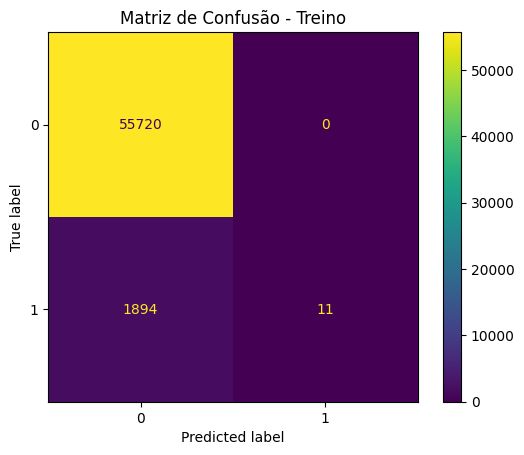

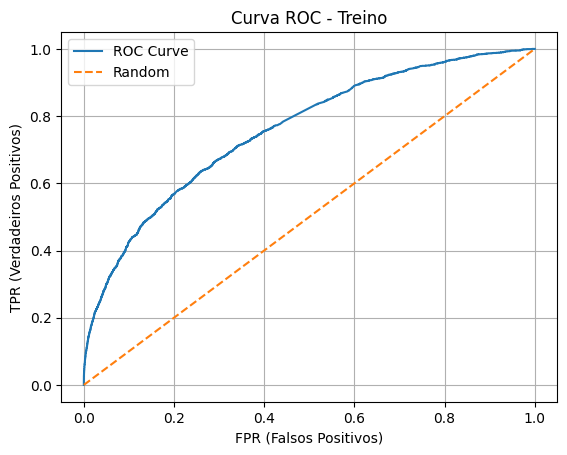

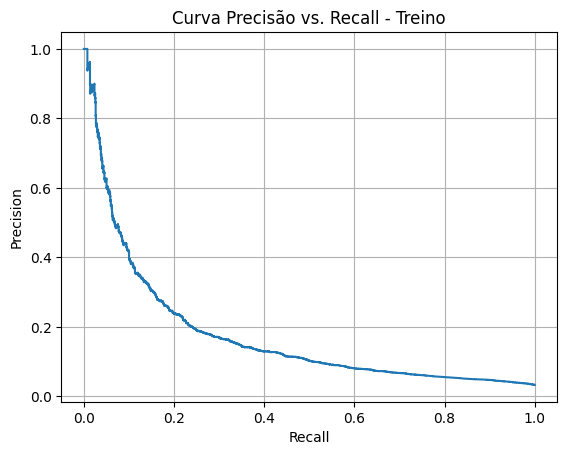

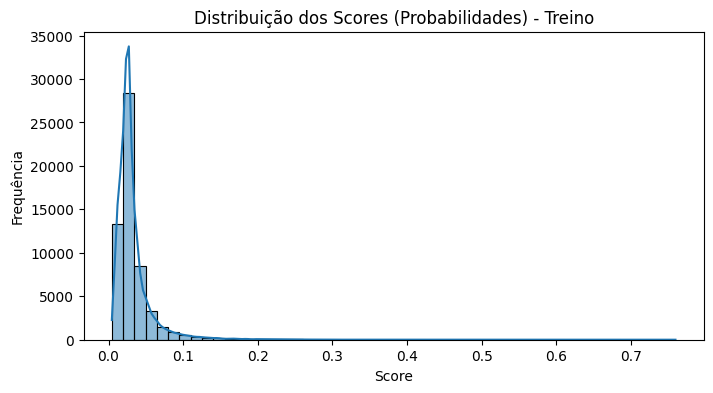

In [ ]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    roc_auc_score, accuracy_score, f1_score,
    precision_score, recall_score, confusion_matrix,
    classification_report, roc_curve, precision_recall_curve,
    ConfusionMatrixDisplay
)
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt
import seaborn as sns


# Avaliar modelo no treino (já que teste não tem target)
y_pred = best_model.predict(X_train)
y_pred_proba = best_model.predict_proba(X_train)[:, 1]

print("\n📊 Métricas no conjunto de treino:")
print(f"AUC: {roc_auc_score(y_train, y_pred_proba):.4f}")
print(f"Accuracy: {accuracy_score(y_train, y_pred):.4f}")
print(f"F1-score: {f1_score(y_train, y_pred):.4f}")
print(f"Precision: {precision_score(y_train, y_pred):.4f}")
print(f"Recall: {recall_score(y_train, y_pred):.4f}")

print("\nRelatório de Classificação:")
print(classification_report(y_train, y_pred))

# Matriz de confusão
cm = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Matriz de Confusão - Treino")
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_train, y_pred_proba)
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random')
plt.xlabel('FPR (Falsos Positivos)')
plt.ylabel('TPR (Verdadeiros Positivos)')
plt.title('Curva ROC - Treino')
plt.legend()
plt.grid()
plt.show()

# Curva Precisão-Recall
precision, recall, _ = precision_recall_curve(y_train, y_pred_proba)
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precisão vs. Recall - Treino')
plt.grid()
plt.show()

# Distribuição dos scores
plt.figure(figsize=(8, 4))
sns.histplot(y_pred_proba, bins=50, kde=True)
plt.title('Distribuição dos Scores (Probabilidades) - Treino')
plt.xlabel('Score')
plt.ylabel('Frequência')
plt.show()

# Previsão no teste (sem target)
y_pred_teste_proba = best_model.predict_proba(X_test)[:, 1]